In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings

warnings.filterwarnings("ignore")

# Set style for better plots
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

In [ ]:
# Load datasets
dataset_dir = "dataset/ml-20m/"
ratings_df = pd.read_csv(dataset_dir + "rating.csv")
movies_df = pd.read_csv(dataset_dir + "movie.csv")
tags_df = pd.read_csv(dataset_dir + "tag.csv")
genome_tags_df = pd.read_csv(dataset_dir + "genome_tags.csv")
genome_scores_df = pd.read_csv(dataset_dir + "genome_scores.csv")
link_df = pd.read_csv(dataset_dir + "link.csv")

print("Dataset loaded successfully!")
print(f"Ratings shape: {ratings_df.shape}")
print(f"Movies shape: {movies_df.shape}")
print(f"Tags shape: {tags_df.shape}")

Dataset loaded successfully!
Ratings shape: (20000263, 4)
Movies shape: (27278, 3)
Tags shape: (465564, 4)


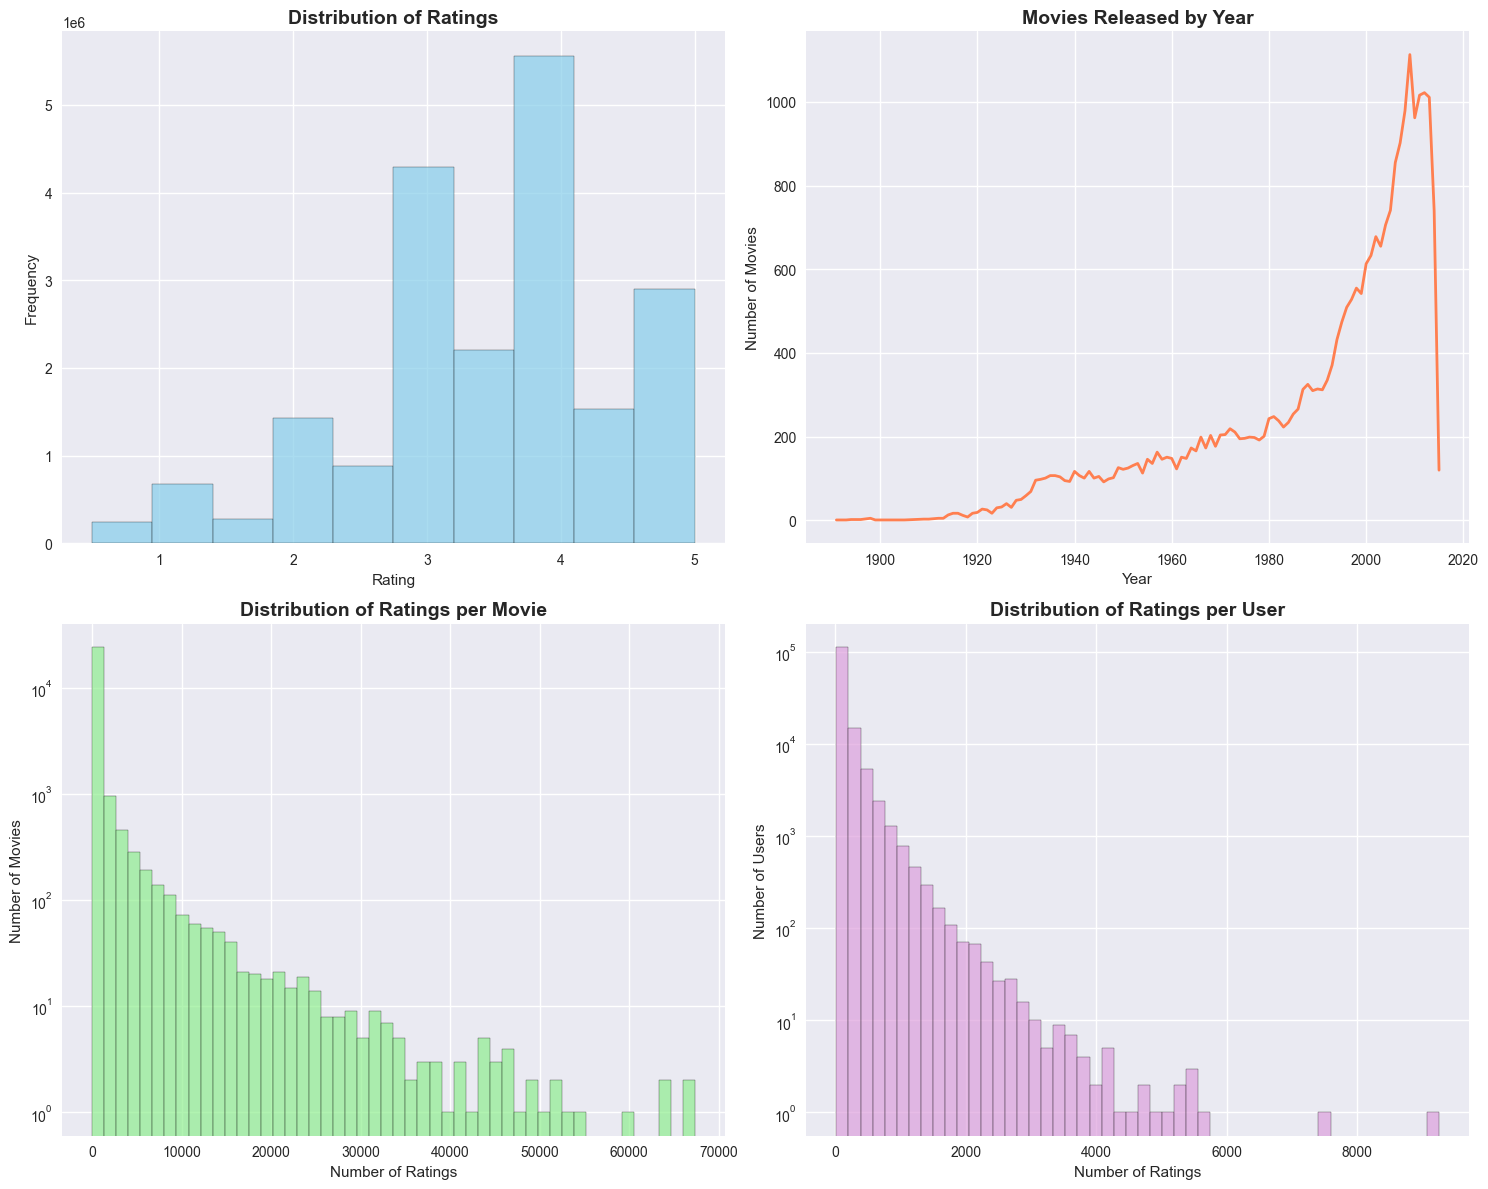

Total ratings: 20,000,263
Unique users: 138,493
Unique movies: 26,744
Average rating: 3.53
Rating std: 1.05


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Rating distribution
axes[0, 0].hist(
    ratings_df["rating"], bins=10, alpha=0.7, color="skyblue", edgecolor="black"
)
axes[0, 0].set_title("Distribution of Ratings", fontsize=14, fontweight="bold")
axes[0, 0].set_xlabel("Rating")
axes[0, 0].set_ylabel("Frequency")

# Movies per year (extract year from title)
movies_df["year"] = movies_df["title"].str.extract(r"\((\d{4})\)").astype(float)
year_counts = movies_df["year"].value_counts().sort_index()
axes[0, 1].plot(year_counts.index, year_counts.values, color="coral", linewidth=2)
axes[0, 1].set_title("Movies Released by Year", fontsize=14, fontweight="bold")
axes[0, 1].set_xlabel("Year")
axes[0, 1].set_ylabel("Number of Movies")

# Ratings per movie
movie_rating_counts = ratings_df["movieId"].value_counts()
axes[1, 0].hist(
    movie_rating_counts, bins=50, alpha=0.7, color="lightgreen", edgecolor="black"
)
axes[1, 0].set_title(
    "Distribution of Ratings per Movie", fontsize=14, fontweight="bold"
)
axes[1, 0].set_xlabel("Number of Ratings")
axes[1, 0].set_ylabel("Number of Movies")
axes[1, 0].set_yscale("log")

# User activity
user_rating_counts = ratings_df["userId"].value_counts()
axes[1, 1].hist(user_rating_counts, bins=50, alpha=0.7, color="plum", edgecolor="black")
axes[1, 1].set_title("Distribution of Ratings per User", fontsize=14, fontweight="bold")
axes[1, 1].set_xlabel("Number of Ratings")
axes[1, 1].set_ylabel("Number of Users")
axes[1, 1].set_yscale("log")

plt.tight_layout()
plt.show()

print(f"Total ratings: {len(ratings_df):,}")
print(f"Unique users: {ratings_df['userId'].nunique():,}")
print(f"Unique movies: {ratings_df['movieId'].nunique():,}")
print(f"Average rating: {ratings_df['rating'].mean():.2f}")
print(f"Rating std: {ratings_df['rating'].std():.2f}")

Filtering movies with at least 10 reviews...
Movies before filtering: 26,744
Movies after filtering (≥10 reviews): 15,451
Ratings before filtering: 20,000,263
Ratings after filtering: 19,964,833


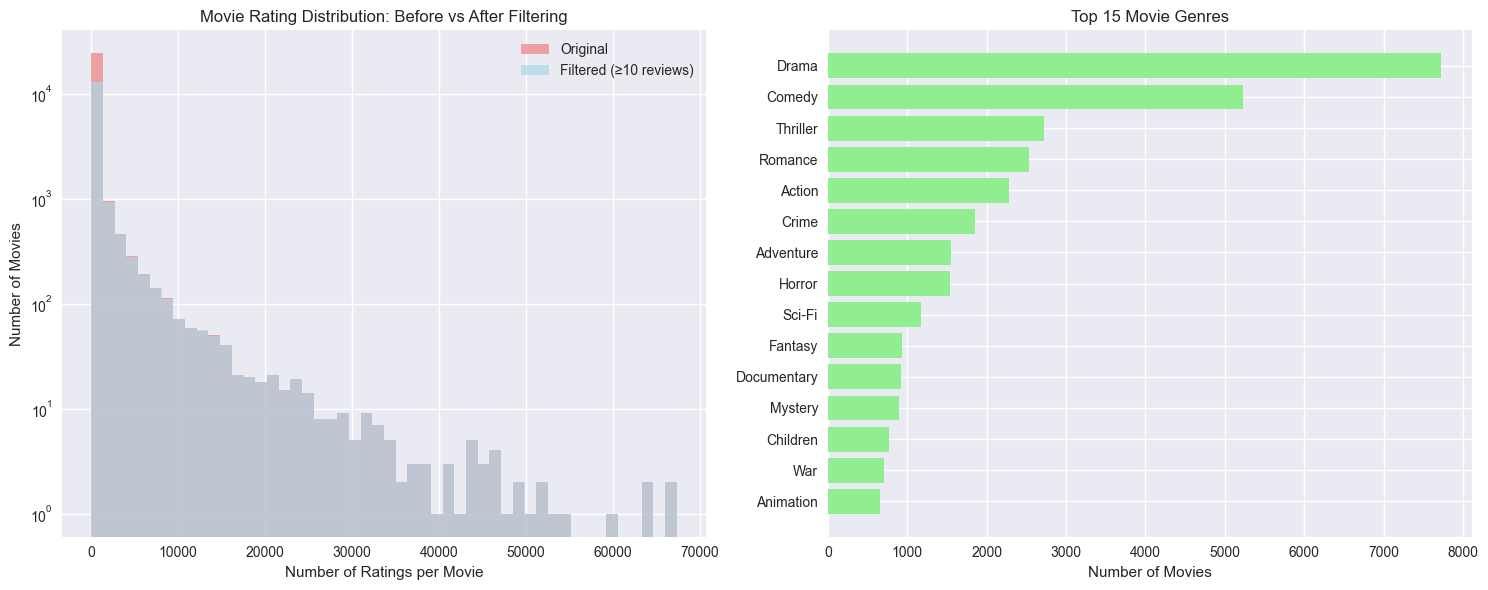

In [ ]:
# Filter movies with at least 10 reviews
print("Filtering movies with at least 10 reviews...")
movie_rating_counts = ratings_df["movieId"].value_counts()
movies_with_min_reviews = movie_rating_counts[movie_rating_counts >= 10].index

print(f"Movies before filtering: {ratings_df['movieId'].nunique():,}")
print(f"Movies after filtering (≥10 reviews): {len(movies_with_min_reviews):,}")

# Filter ratings and movies dataframes
ratings_filtered = ratings_df[
    ratings_df["movieId"].isin(movies_with_min_reviews)
].copy()
movies_filtered = movies_df[movies_df["movieId"].isin(movies_with_min_reviews)].copy()

print(f"Ratings before filtering: {len(ratings_df):,}")
print(f"Ratings after filtering: {len(ratings_filtered):,}")

# Update dataframes
ratings_df = ratings_filtered
movies_df = movies_filtered

# Visualization of filtering effect
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Before and after comparison
original_counts = movie_rating_counts
filtered_counts = ratings_df["movieId"].value_counts()

ax1.hist(original_counts, bins=50, alpha=0.7, label="Original", color="lightcoral")
ax1.hist(
    filtered_counts,
    bins=50,
    alpha=0.7,
    label="Filtered (≥10 reviews)",
    color="lightblue",
)
ax1.set_xlabel("Number of Ratings per Movie")
ax1.set_ylabel("Number of Movies")
ax1.set_title("Movie Rating Distribution: Before vs After Filtering")
ax1.legend()
ax1.set_yscale("log")

# Genre distribution
genres_list = []
for genres in movies_df["genres"].dropna():
    genres_list.extend(genres.split("|"))

genre_counts = Counter(genres_list)
top_genres = dict(genre_counts.most_common(15))

ax2.barh(list(top_genres.keys()), list(top_genres.values()), color="lightgreen")
ax2.set_xlabel("Number of Movies")
ax2.set_title("Top 15 Movie Genres")
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

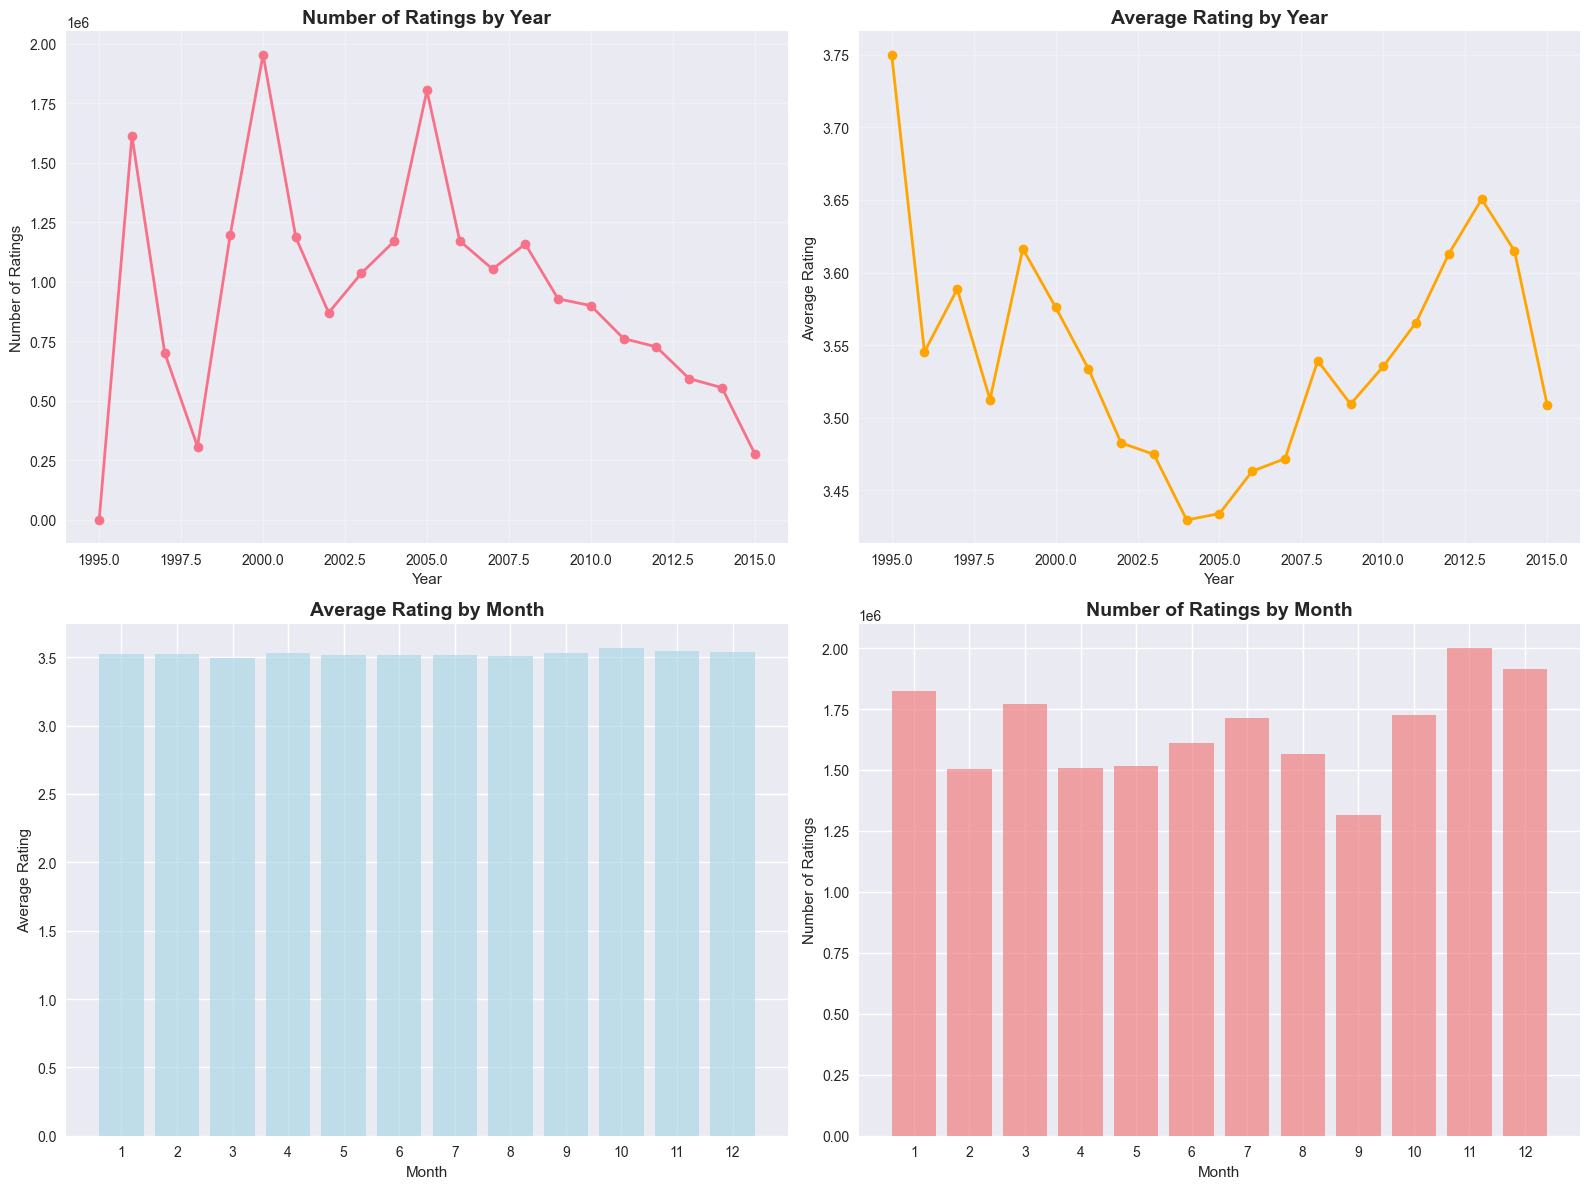

In [ ]:
# Rating patterns over time
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Convert timestamp to datetime - handle both string and numeric formats
try:
    # Try as Unix timestamp first
    ratings_df["datetime"] = pd.to_datetime(ratings_df["timestamp"], unit="s")
except (ValueError, TypeError):
    # If that fails, try as string datetime
    ratings_df["datetime"] = pd.to_datetime(ratings_df["timestamp"])

ratings_df["year"] = ratings_df["datetime"].dt.year
ratings_df["month"] = ratings_df["datetime"].dt.month

# Ratings over time (yearly)
yearly_ratings = ratings_df.groupby("year").size()
axes[0, 0].plot(yearly_ratings.index, yearly_ratings.values, marker="o", linewidth=2)
axes[0, 0].set_title("Number of Ratings by Year", fontsize=14, fontweight="bold")
axes[0, 0].set_xlabel("Year")
axes[0, 0].set_ylabel("Number of Ratings")
axes[0, 0].grid(True, alpha=0.3)

# Average rating by year
avg_rating_by_year = ratings_df.groupby("year")["rating"].mean()
axes[0, 1].plot(
    avg_rating_by_year.index,
    avg_rating_by_year.values,
    marker="o",
    color="orange",
    linewidth=2,
)
axes[0, 1].set_title("Average Rating by Year", fontsize=14, fontweight="bold")
axes[0, 1].set_xlabel("Year")
axes[0, 1].set_ylabel("Average Rating")
axes[0, 1].grid(True, alpha=0.3)

# Rating distribution by month
monthly_avg = ratings_df.groupby("month")["rating"].mean()
axes[1, 0].bar(monthly_avg.index, monthly_avg.values, color="lightblue", alpha=0.7)
axes[1, 0].set_title("Average Rating by Month", fontsize=14, fontweight="bold")
axes[1, 0].set_xlabel("Month")
axes[1, 0].set_ylabel("Average Rating")
axes[1, 0].set_xticks(range(1, 13))

# Rating count by month
monthly_count = ratings_df.groupby("month").size()
axes[1, 1].bar(monthly_count.index, monthly_count.values, color="lightcoral", alpha=0.7)
axes[1, 1].set_title("Number of Ratings by Month", fontsize=14, fontweight="bold")
axes[1, 1].set_xlabel("Month")
axes[1, 1].set_ylabel("Number of Ratings")
axes[1, 1].set_xticks(range(1, 13))

plt.tight_layout()
plt.show()

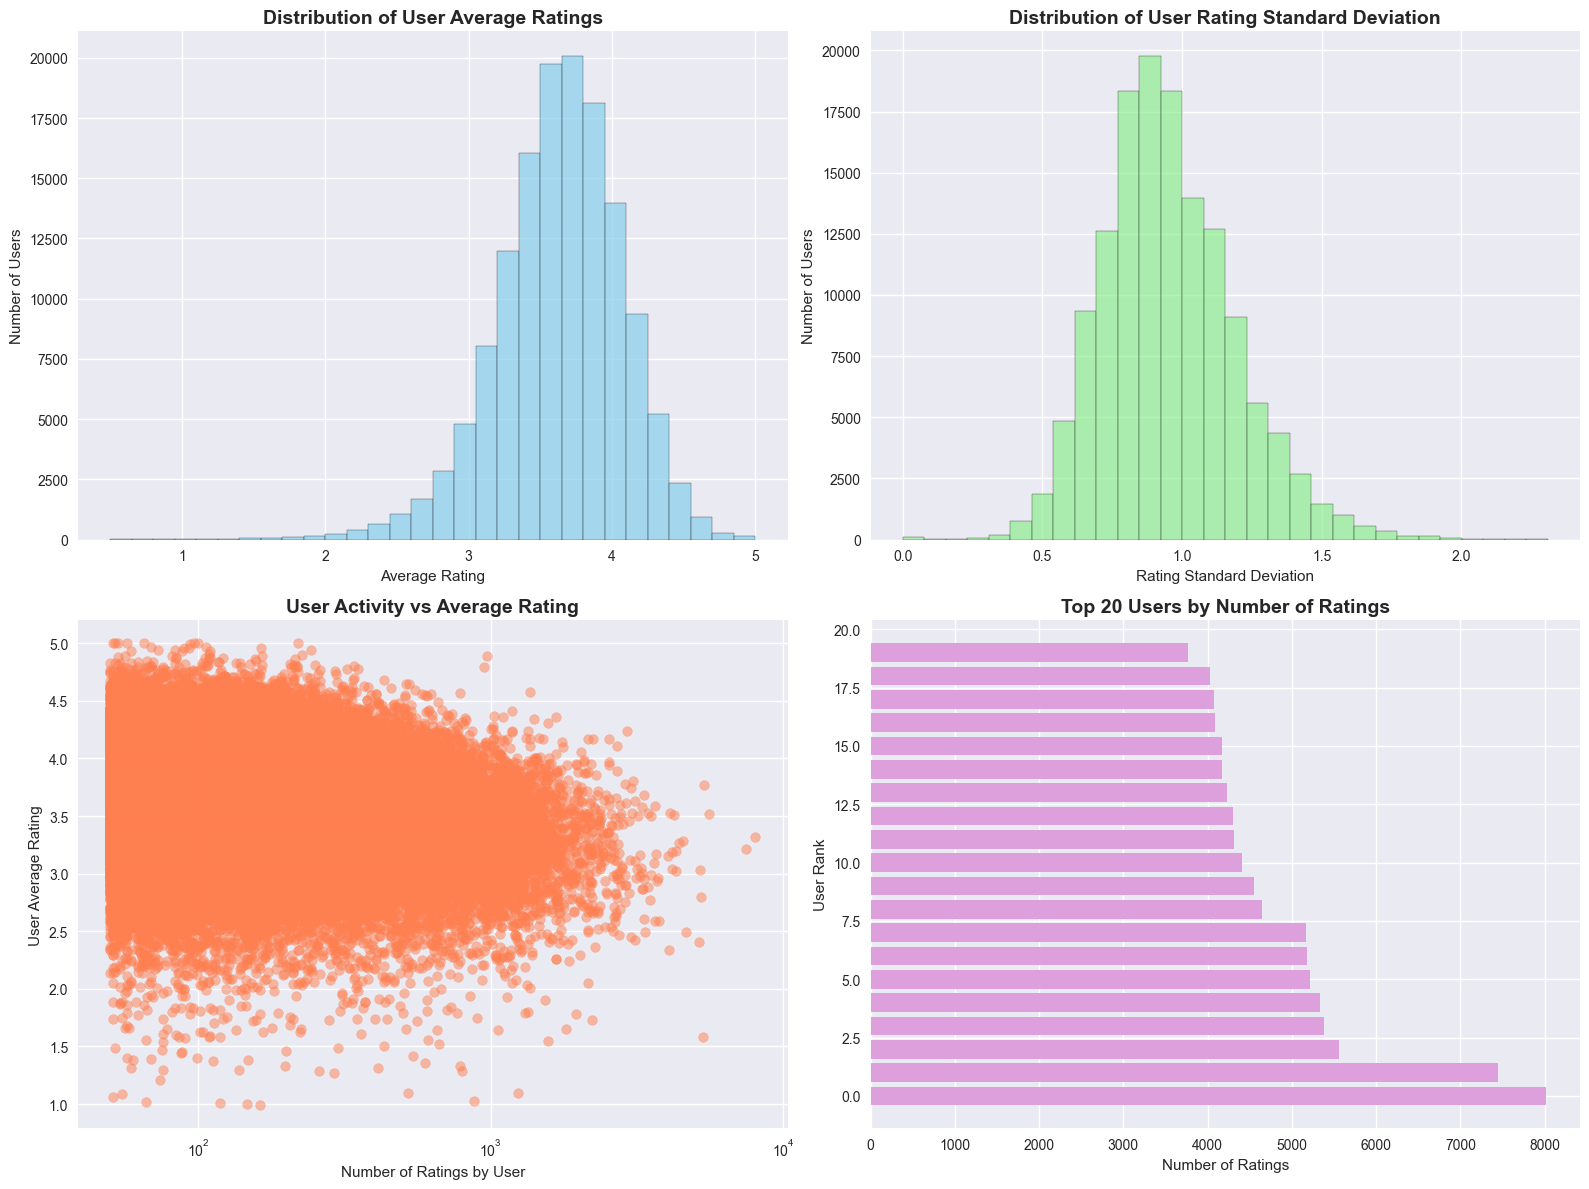

Most active user has rated 8,018 movies
Average user rates 144.2 movies
Median user rates 68.0 movies


In [ ]:
# User behavior analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# User rating statistics
user_stats = (
    ratings_df.groupby("userId")
    .agg({"rating": ["count", "mean", "std"], "movieId": "nunique"})
    .round(2)
)

user_stats.columns = ["rating_count", "avg_rating", "rating_std", "unique_movies"]
user_stats = user_stats.reset_index()

# Distribution of user average ratings
axes[0, 0].hist(
    user_stats["avg_rating"].dropna(),
    bins=30,
    alpha=0.7,
    color="skyblue",
    edgecolor="black",
)
axes[0, 0].set_title(
    "Distribution of User Average Ratings", fontsize=14, fontweight="bold"
)
axes[0, 0].set_xlabel("Average Rating")
axes[0, 0].set_ylabel("Number of Users")

# User rating standard deviation
axes[0, 1].hist(
    user_stats["rating_std"].dropna(),
    bins=30,
    alpha=0.7,
    color="lightgreen",
    edgecolor="black",
)
axes[0, 1].set_title(
    "Distribution of User Rating Standard Deviation", fontsize=14, fontweight="bold"
)
axes[0, 1].set_xlabel("Rating Standard Deviation")
axes[0, 1].set_ylabel("Number of Users")

# Correlation between user activity and average rating
scatter_data = user_stats[
    user_stats["rating_count"] >= 50
]  # Users with at least 50 ratings
axes[1, 0].scatter(
    scatter_data["rating_count"], scatter_data["avg_rating"], alpha=0.5, color="coral"
)
axes[1, 0].set_title("User Activity vs Average Rating", fontsize=14, fontweight="bold")
axes[1, 0].set_xlabel("Number of Ratings by User")
axes[1, 0].set_ylabel("User Average Rating")
axes[1, 0].set_xscale("log")

# Top users by number of ratings
top_users = user_stats.nlargest(20, "rating_count")
axes[1, 1].barh(range(len(top_users)), top_users["rating_count"], color="plum")
axes[1, 1].set_title(
    "Top 20 Users by Number of Ratings", fontsize=14, fontweight="bold"
)
axes[1, 1].set_xlabel("Number of Ratings")
axes[1, 1].set_ylabel("User Rank")

plt.tight_layout()
plt.show()

print(f"Most active user has rated {user_stats['rating_count'].max():,} movies")
print(f"Average user rates {user_stats['rating_count'].mean():.1f} movies")
print(f"Median user rates {user_stats['rating_count'].median():.1f} movies")

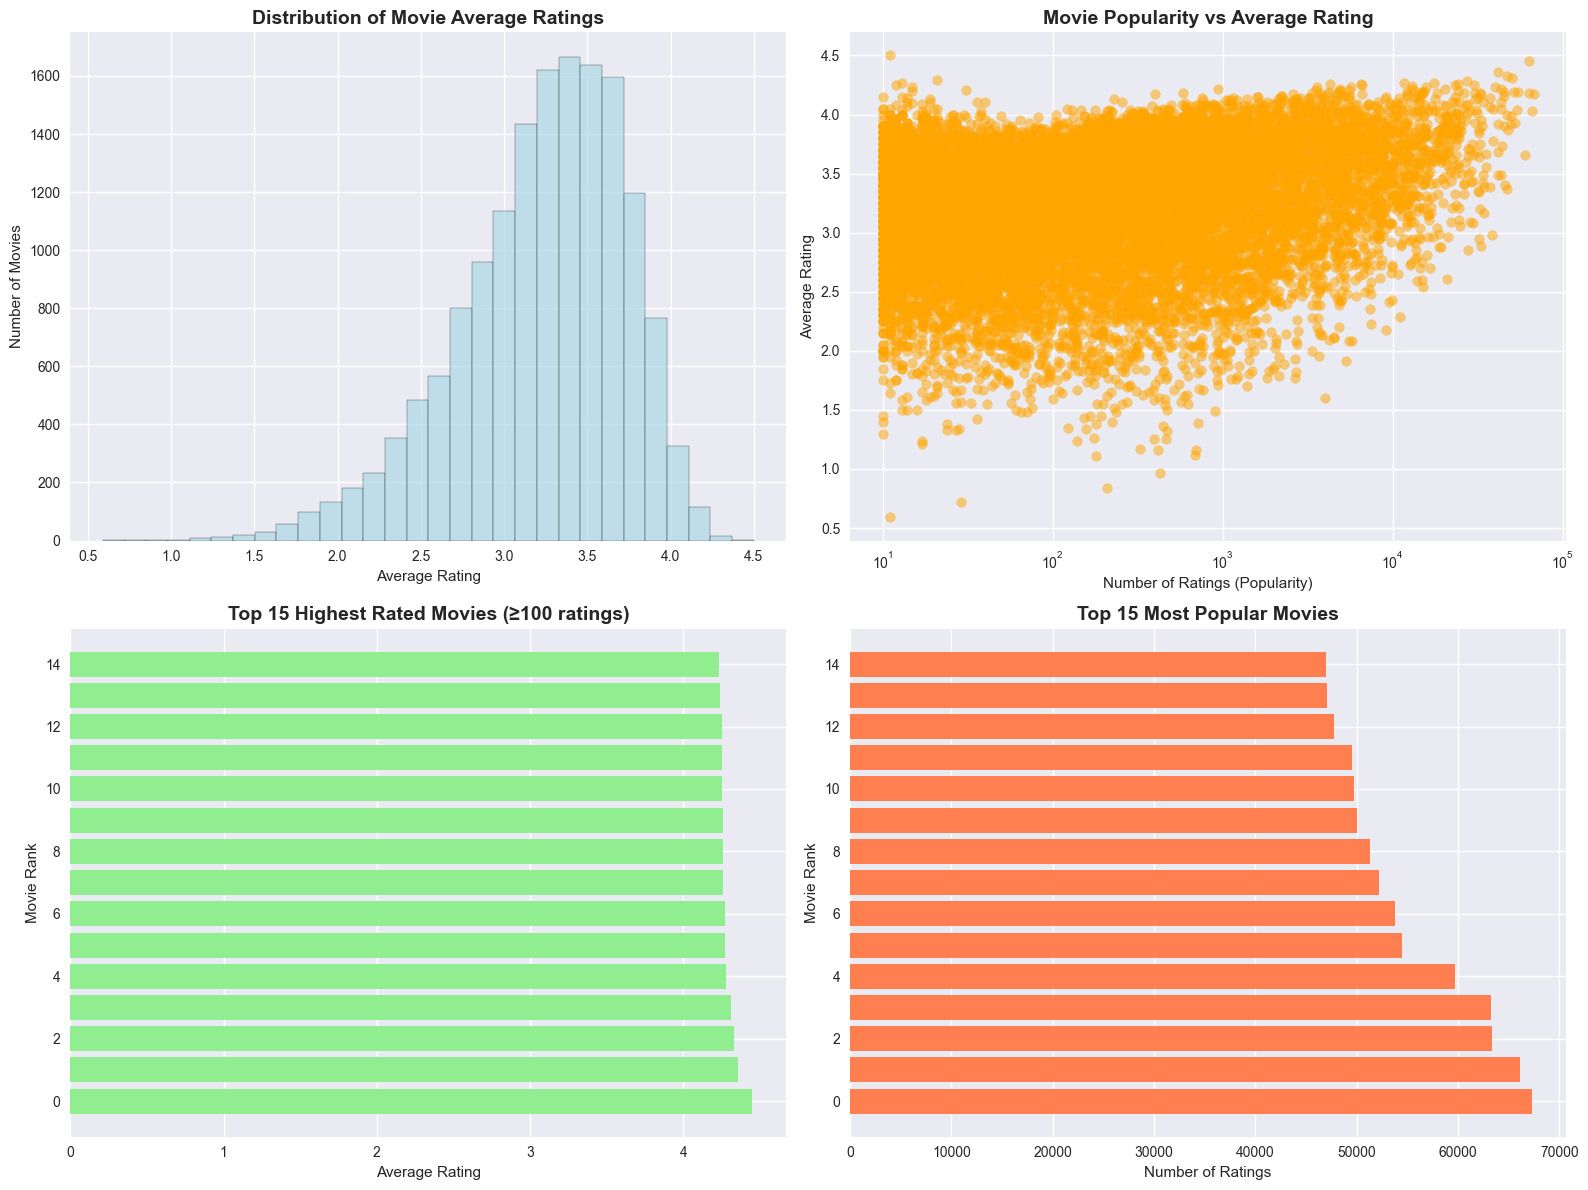

Top 10 Highest Rated Movies (≥100 ratings):
                                        title  avg_rating  rating_count
             Shawshank Redemption, The (1994)        4.45         63366
                        Godfather, The (1972)        4.36         41355
                   Usual Suspects, The (1995)        4.33         47006
                      Schindler's List (1993)        4.31         50054
               Godfather: Part II, The (1974)        4.28         27398
                           Rear Window (1954)        4.27         17449
  Seven Samurai (Shichinin no samurai) (1954)        4.27         11611
                            Casablanca (1942)        4.26         24349
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)        4.26          6525
                      Band of Brothers (2001)        4.26          4305


In [ ]:
# Movie popularity and rating analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Movie statistics
movie_stats = (
    ratings_df.groupby("movieId")
    .agg({"rating": ["count", "mean", "std"], "userId": "nunique"})
    .round(2)
)

movie_stats.columns = ["rating_count", "avg_rating", "rating_std", "unique_users"]
movie_stats = movie_stats.reset_index()

# Merge with movie titles
movie_stats = movie_stats.merge(
    movies_df[["movieId", "title"]], on="movieId", how="left"
)

# Distribution of movie average ratings
axes[0, 0].hist(
    movie_stats["avg_rating"], bins=30, alpha=0.7, color="lightblue", edgecolor="black"
)
axes[0, 0].set_title(
    "Distribution of Movie Average Ratings", fontsize=14, fontweight="bold"
)
axes[0, 0].set_xlabel("Average Rating")
axes[0, 0].set_ylabel("Number of Movies")

# Relationship between popularity and rating
axes[0, 1].scatter(
    movie_stats["rating_count"], movie_stats["avg_rating"], alpha=0.5, color="orange"
)
axes[0, 1].set_title(
    "Movie Popularity vs Average Rating", fontsize=14, fontweight="bold"
)
axes[0, 1].set_xlabel("Number of Ratings (Popularity)")
axes[0, 1].set_ylabel("Average Rating")
axes[0, 1].set_xscale("log")

# Top rated movies (with at least 100 ratings)
top_rated = movie_stats[movie_stats["rating_count"] >= 100].nlargest(15, "avg_rating")
axes[1, 0].barh(range(len(top_rated)), top_rated["avg_rating"], color="lightgreen")
axes[1, 0].set_title(
    "Top 15 Highest Rated Movies (≥100 ratings)", fontsize=14, fontweight="bold"
)
axes[1, 0].set_xlabel("Average Rating")
axes[1, 0].set_ylabel("Movie Rank")

# Most popular movies
most_popular = movie_stats.nlargest(15, "rating_count")
axes[1, 1].barh(range(len(most_popular)), most_popular["rating_count"], color="coral")
axes[1, 1].set_title("Top 15 Most Popular Movies", fontsize=14, fontweight="bold")
axes[1, 1].set_xlabel("Number of Ratings")
axes[1, 1].set_ylabel("Movie Rank")

plt.tight_layout()
plt.show()

print("Top 10 Highest Rated Movies (≥100 ratings):")
print(
    top_rated[["title", "avg_rating", "rating_count"]].head(10).to_string(index=False)
)

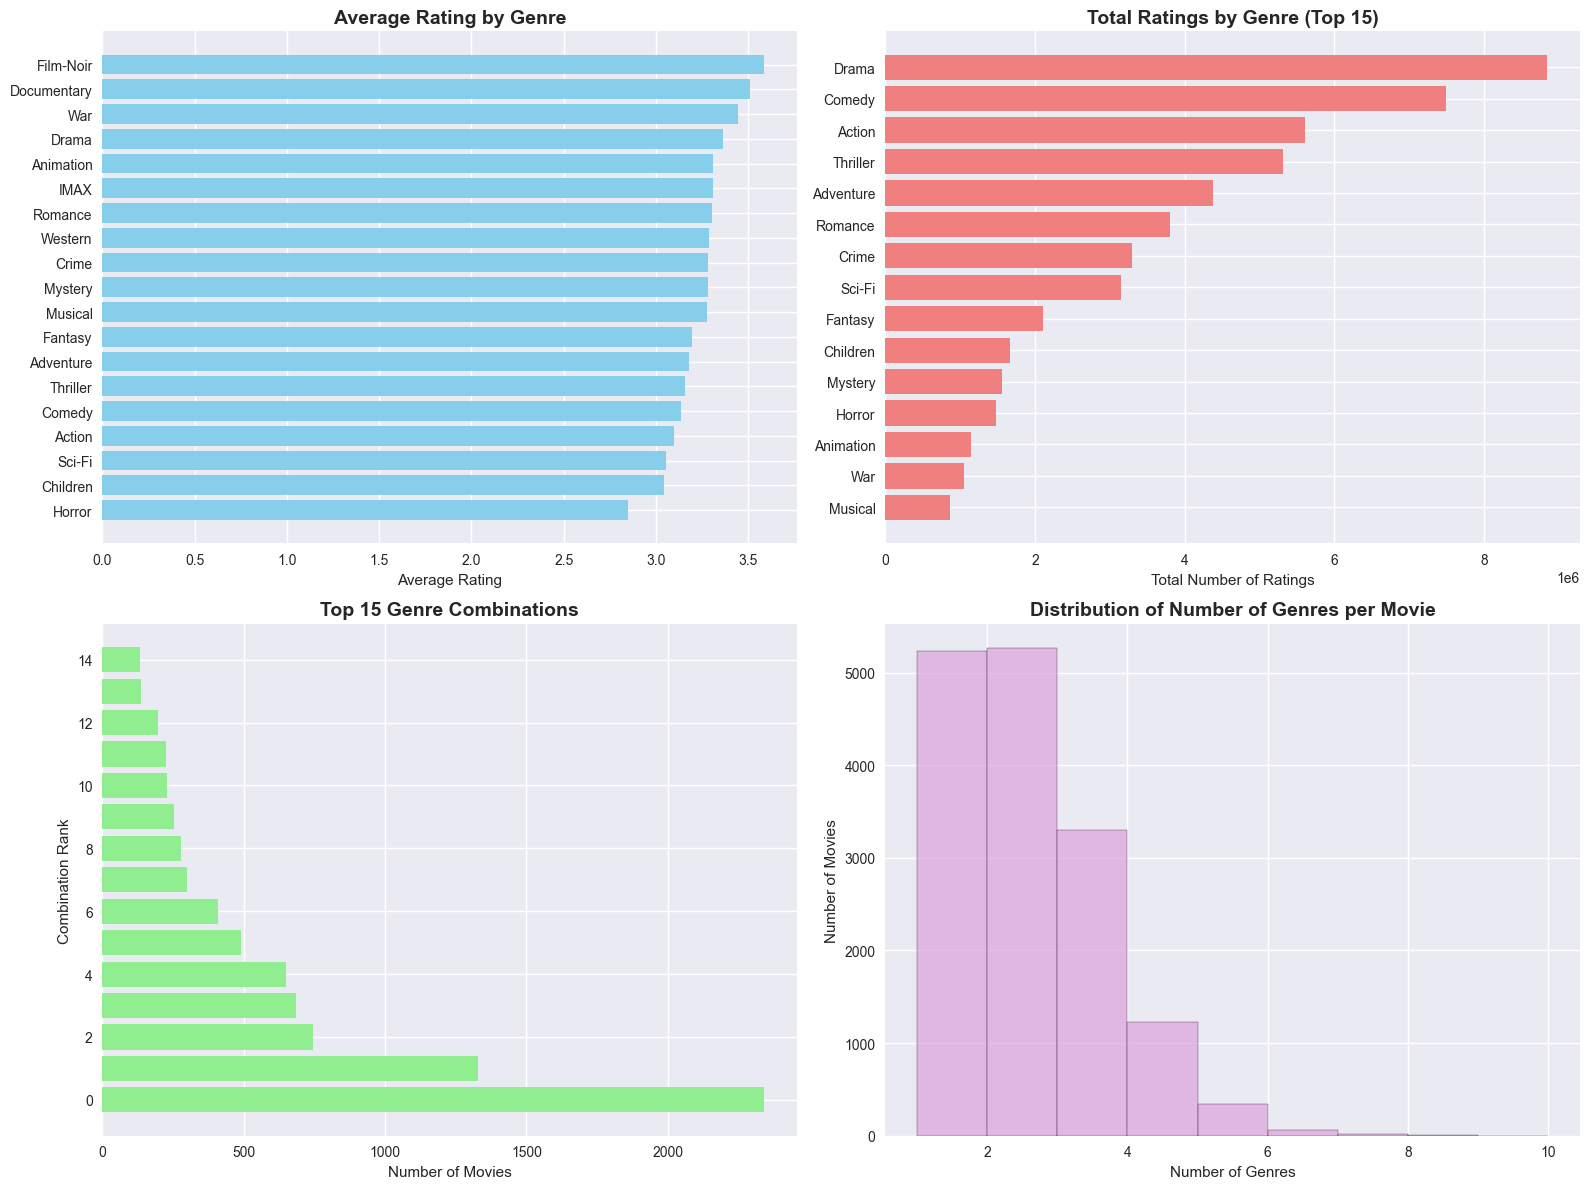

Average number of genres per movie: 2.12
Most common number of genres: 2


In [ ]:
# Genre analysis in depth
# Create genre matrix
genres_df = movies_df["genres"].str.get_dummies(sep="|")
movie_genre_df = pd.concat([movies_df[["movieId", "title"]], genres_df], axis=1)

# Merge with rating statistics
genre_analysis = movie_genre_df.merge(
    movie_stats[["movieId", "avg_rating", "rating_count"]], on="movieId"
)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Average rating by genre
genre_ratings = {}
for genre in genres_df.columns:
    if genre != "(no genres listed)":
        genre_movies = genre_analysis[genre_analysis[genre] == 1]
        if len(genre_movies) > 0:
            genre_ratings[genre] = genre_movies["avg_rating"].mean()

genre_ratings_sorted = dict(
    sorted(genre_ratings.items(), key=lambda x: x[1], reverse=True)
)

axes[0, 0].barh(
    list(genre_ratings_sorted.keys()),
    list(genre_ratings_sorted.values()),
    color="skyblue",
)
axes[0, 0].set_title("Average Rating by Genre", fontsize=14, fontweight="bold")
axes[0, 0].set_xlabel("Average Rating")
axes[0, 0].invert_yaxis()

# Genre popularity (number of ratings)
genre_popularity = {}
for genre in genres_df.columns:
    if genre != "(no genres listed)":
        genre_movies = genre_analysis[genre_analysis[genre] == 1]
        if len(genre_movies) > 0:
            genre_popularity[genre] = genre_movies["rating_count"].sum()

genre_pop_sorted = dict(
    sorted(genre_popularity.items(), key=lambda x: x[1], reverse=True)
)

axes[0, 1].barh(
    list(genre_pop_sorted.keys())[:15],
    list(genre_pop_sorted.values())[:15],
    color="lightcoral",
)
axes[0, 1].set_title("Total Ratings by Genre (Top 15)", fontsize=14, fontweight="bold")
axes[0, 1].set_xlabel("Total Number of Ratings")
axes[0, 1].invert_yaxis()

# Genre combinations analysis
genre_combinations = movies_df["genres"].value_counts().head(15)
axes[1, 0].barh(
    range(len(genre_combinations)), genre_combinations.values, color="lightgreen"
)
axes[1, 0].set_title("Top 15 Genre Combinations", fontsize=14, fontweight="bold")
axes[1, 0].set_xlabel("Number of Movies")
axes[1, 0].set_ylabel("Combination Rank")

# Number of genres per movie
movies_df["genre_count"] = movies_df["genres"].str.count("\|") + 1
axes[1, 1].hist(
    movies_df["genre_count"],
    bins=range(1, 11),
    alpha=0.7,
    color="plum",
    edgecolor="black",
)
axes[1, 1].set_title(
    "Distribution of Number of Genres per Movie", fontsize=14, fontweight="bold"
)
axes[1, 1].set_xlabel("Number of Genres")
axes[1, 1].set_ylabel("Number of Movies")

plt.tight_layout()
plt.show()

print(f"Average number of genres per movie: {movies_df['genre_count'].mean():.2f}")
print(f"Most common number of genres: {movies_df['genre_count'].mode().iloc[0]}")

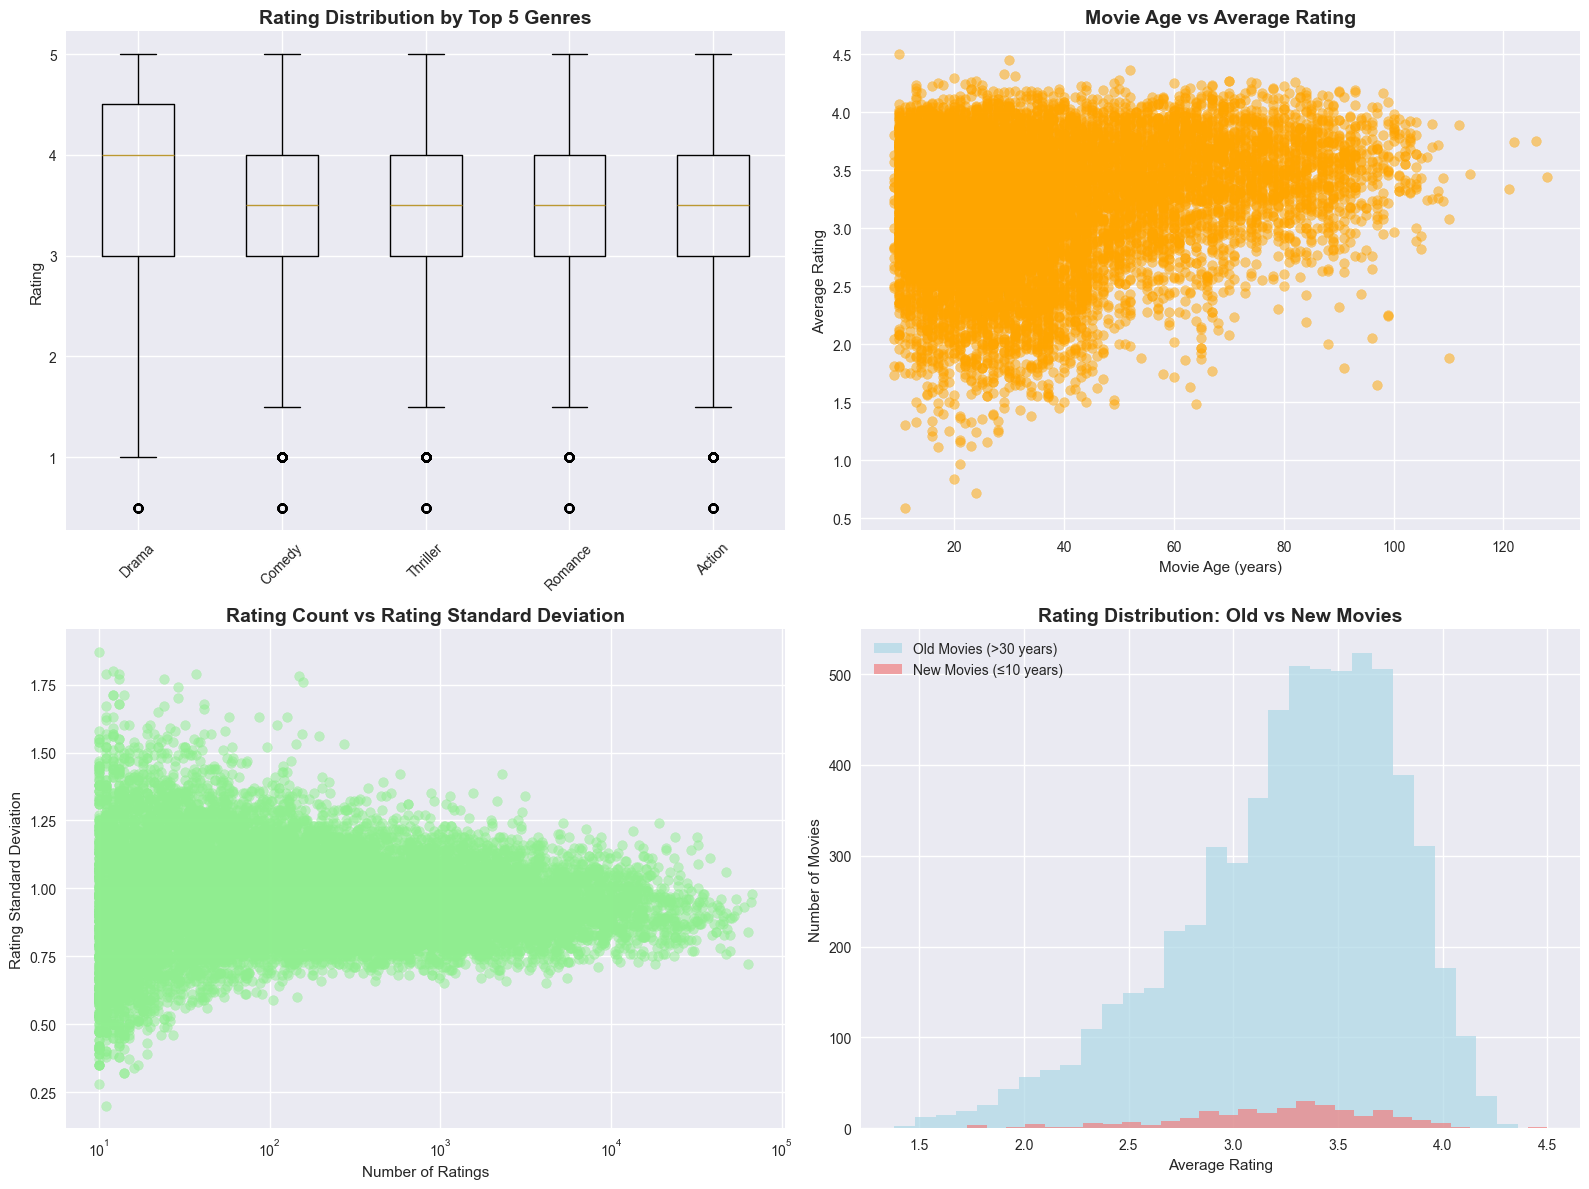

Statistical Summary:
Correlation between movie age and average rating: 0.151
Correlation between popularity and rating: 0.196
Average rating for old movies (>30 years): 3.268
Average rating for new movies (≤10 years): 3.210


In [ ]:
# Rating patterns and correlations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Optimized rating distribution by genre (vectorized approach)
top_5_genres = list(genre_counts.most_common(5))
rating_by_genre_data = []
genre_labels = []

# Create a merged dataset once for efficiency
ratings_with_genres = ratings_df.merge(genre_analysis, on="movieId", how="inner")

for genre, _ in top_5_genres:
    if genre != "(no genres listed)":
        # Vectorized filtering - much faster than nested loops
        genre_ratings = ratings_with_genres[ratings_with_genres[genre] == 1]["rating"]
        # Sample efficiently if needed
        if len(genre_ratings) > 5000:
            genre_ratings = genre_ratings.sample(n=5000, random_state=42)
        rating_by_genre_data.append(genre_ratings.tolist())
        genre_labels.append(genre)

axes[0, 0].boxplot(rating_by_genre_data, labels=genre_labels)
axes[0, 0].set_title(
    "Rating Distribution by Top 5 Genres", fontsize=14, fontweight="bold"
)
axes[0, 0].set_ylabel("Rating")
axes[0, 0].tick_params(axis="x", rotation=45)

# Correlation between movie age and average rating
current_year = 2024
movies_df["age"] = current_year - movies_df["year"]
movie_age_rating = movie_stats.merge(movies_df[["movieId", "age"]], on="movieId")
movie_age_rating = movie_age_rating.dropna()

axes[0, 1].scatter(
    movie_age_rating["age"], movie_age_rating["avg_rating"], alpha=0.5, color="orange"
)
axes[0, 1].set_title("Movie Age vs Average Rating", fontsize=14, fontweight="bold")
axes[0, 1].set_xlabel("Movie Age (years)")
axes[0, 1].set_ylabel("Average Rating")

# Rating variance analysis
axes[1, 0].scatter(
    movie_stats["rating_count"],
    movie_stats["rating_std"],
    alpha=0.5,
    color="lightgreen",
)
axes[1, 0].set_title(
    "Rating Count vs Rating Standard Deviation", fontsize=14, fontweight="bold"
)
axes[1, 0].set_xlabel("Number of Ratings")
axes[1, 0].set_ylabel("Rating Standard Deviation")
axes[1, 0].set_xscale("log")

# Rating distribution comparison: old vs new movies (pre-computed filter)
age_filter_old = movie_age_rating["age"] > 30
age_filter_new = movie_age_rating["age"] <= 10
old_movies = movie_age_rating.loc[age_filter_old, "avg_rating"]
new_movies = movie_age_rating.loc[age_filter_new, "avg_rating"]

axes[1, 1].hist(
    old_movies, alpha=0.7, label="Old Movies (>30 years)", bins=30, color="lightblue"
)
axes[1, 1].hist(
    new_movies, alpha=0.7, label="New Movies (≤10 years)", bins=30, color="lightcoral"
)
axes[1, 1].set_title(
    "Rating Distribution: Old vs New Movies", fontsize=14, fontweight="bold"
)
axes[1, 1].set_xlabel("Average Rating")
axes[1, 1].set_ylabel("Number of Movies")
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Pre-compute correlations for efficiency
age_rating_corr = movie_age_rating["age"].corr(movie_age_rating["avg_rating"])
popularity_rating_corr = movie_stats["rating_count"].corr(movie_stats["avg_rating"])
old_movies_mean = old_movies.mean()
new_movies_mean = new_movies.mean()

# Statistical summary
print("Statistical Summary:")
print(f"Correlation between movie age and average rating: {age_rating_corr:.3f}")
print(f"Correlation between popularity and rating: {popularity_rating_corr:.3f}")
print(f"Average rating for old movies (>30 years): {old_movies_mean:.3f}")
print(f"Average rating for new movies (≤10 years): {new_movies_mean:.3f}")